In [1]:
using DifferentialEquations
include("src/Utils.jl")
include("src/Models.jl")
include("src/Params.jl");
using Plots; pythonplot();
using Statistics
using Contour

## Add KaiBC-KaiA binding equilibrium to the model

In [2]:
"""
At low temperatures kSU is slowed down. See Rust lab data pending citation.
A-SB binding equilibrium is explicitly modeled (as opposed to the all-or-none binding in the original Phong model)
"""
function kaiabc_phong_arbitrary_binding!(dX, X, p, t)

    # U: unphosphorylated. T: only T432 phosphorylated. S: only S431 phosphorylated
    # D: doubly phosphorylated. DB: D KaiC bound with KaiB. SB: S KaiC bound with KaiB
    U, T, D, S, DB, SB = X

    # k's are reaction constants (here all are 1st-order), e.g., 
    # kTU is the per reactant rate transfering from T to U
    # kCIhyd: ATP hydrolysis rate of the CI ring
    # KA: [KaiA] that activates kinase activity to half maximum
    # A0: initial [KaiA]
    # fATP = [ATP] / ([ATP] + [ADP])
    # N: # A sequestered per D. M: # A sequestered per S
    kUTA, kTU, kTUA, kTDA, kDT, kDTA, kDS, kDSA, kSDA, kSU, kSUA, kUSA, kCIhyd,
    KA, A0, fATP, K_SBA = p

    hill(x) = x/(x + KA)
    
    # Arbitrary KaiA sequestration function
    # f: [BC]total -> [A]free
    A = SB >= K_SBA ? 0 : A0

    #           U,      T,      D,      S,      DB,     SB
    dephos_r  = [0      kTU     0       kSU     0       kSU
                 0      0       kDT     0       kDT     0
                 0      0       0       0       0       0
                 0      0       kDS     0       0       0
                 0      0       0       0       0       0
                 0      0       0       0       kDS     0] +
                [0      kTUA    0       kSUA    0       kSUA
                 0      0       kDTA    0       kDTA    0
                 0      0       0       0       0       0
                 0      0       kDSA    0       0       0
                 0      0       0       0       0       0
                 0      0       0       0       kDSA    0]*hill(A)
    
    #         U     T       D       S       DB      SB
    phos_r = [0     0       0       0       0       0
              kUTA  0       0       0       0       0
              0     kTDA    0       kSDA    0       0
              kUSA  0       0       0       0       0
              0     0       0       0       0       kSDA
              0     0       0       0       0       0]*hill(A)*fATP

    #        U      T       D       S       DB      SB
    hyd_r = [0      0       0       0       0       0
             0      0       0       0       0       0
             0      0       0       0       0       0
             0      0       0       0       0       0
             0      0       kCIhyd  0       0       0
             0      0       0       kCIhyd  0       0]

    r = dephos_r + phos_r + hyd_r

    # conservation
    r -= I(size(r)[1]) .* sum(r, dims=1)

    # (for AD) Zygote.Buffer doesn't support in-place broadcast .=
    # see https://discourse.julialang.org/t/how-to-use-initialize-zygote-buffer/87653
    dX[:] = r*X
    nothing
end

kaiabc_phong_arbitrary_binding!

Check out the trajectories

In [21]:
A0 = 1.0
fATP = 1.0

kSU_cold = 0.2
K_SBA = 0.05


p_ori = (kUTA, kTU, kTUA, kTDA, kDT, kDTA, kDS, kDSA, kSDA, kSU, kSUA, kUSA, kCIhyd,
KA, A0, fATP, N, M);

p = (kUTA, kTU, kTUA, kTDA, kDT, kDTA, kDS, kDSA, kSDA, kSU_cold, kSUA, kUSA, kCIhyd,
KA, A0, fATP, K_SBA);

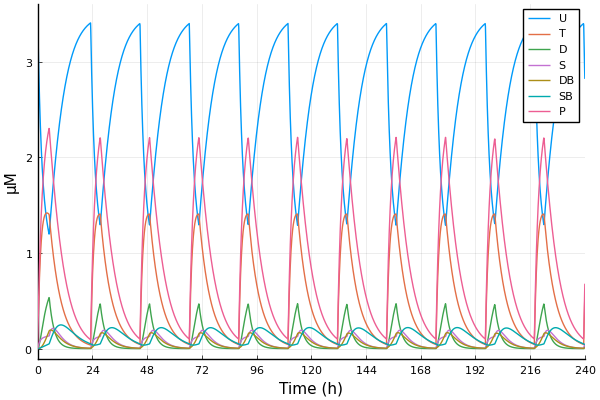

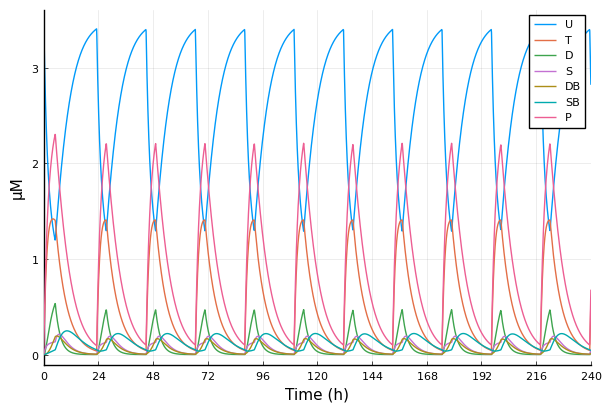

In [22]:
# U, T, D, S, DB, SB
p0 = [3.5, 0, 0, 0, 0, 0]

tmax = 240

prob = ODEProblem(kaiabc_phong_arbitrary_binding!, p0, (0.0, tmax), p)
sol = solve(prob, Tsit5(), saveat = 0.1)

p = plot(sol, labels=["U" "T" "D" "S" "DB" "SB"])
plot!(sol.t, 3.5*phospho_C(sol.u), label="P", fmt=:png)
xticks!(0:24:tmax)
xlabel!("Time (h)")
ylabel!("μM")
display(p)



$$
K_{ASB} = \frac{[\text{KaiA}]_{free}\cdot[\text{SB}]_{free}}{[(\text{KaiA})_M:\text{SB}]}
$$

Heatmap: checking out combinations of $k_{SU}$ and $K_{A:SB}$

In [36]:
kSU_vec = 0.05:5e-3:0.15
K_SBA_vec = 0.004:2e-3:0.04


# additional params
A0 = 1.0
fATP = 1.0

# KaiBC-KaiA binding stoichiometry
M_new = 6.

# find period numerically
per_mat = zeros(length(kSU_vec), length(K_SBA_vec))
amp_mat = zeros(length(kSU_vec), length(K_SBA_vec))
pC_mat = zeros(length(kSU_vec), length(K_SBA_vec))

for (i, kSU_cold) in enumerate(kSU_vec)
    for (j, K_SBA) in enumerate(K_SBA_vec)
        # initial conditions
        u0 = [3.5, 0, 0, 0, 0, 0]
        
        p = (kUTA, kTU, kTUA, kTDA, kDT, kDTA, kDS, kDSA, kSDA, kSU_cold, kSUA, kUSA, kCIhyd,
        KA, A0, fATP, K_SBA)
        
        conv_t, amplitude, per, phase = 
            attracted_to(kaiabc_phong_arbitrary_binding!, u0, 168, p; 
            burnin=96, conv_tol=5e-3, amp_cutoff=5e-2, tmax_stop=1e3)

        per_mat[i, j] = per == -1 ? NaN : per
        amp_mat[i, j] = amplitude == -1 ? NaN : amplitude
        
        # solve it one more time to get mean fraction of pC
        prob = ODEProblem(kaiabc_phong_arbitrary_binding!, u0, (0.0, conv_t + 1000.), p)
        sol = solve(prob, reltol=1e-8, abstol=1e-8)
        mean_pC = conv_t < 0 ? NaN : mean(phospho_C(sol.u[sol.t .> conv_t]))
        
        pC_mat[i, j] = mean_pC
        
        print("kSU=$(kSU_cold); K_SBA=$(K_SBA); amp=$(amplitude); per=$(per); pC=$(mean_pC)\n")
    end
end

kSU=0.05; K_SBA=0.004; amp=0.055187727080685686; per=36.12784; pC=0.022910894877877664
kSU=0.05; K_SBA=0.006; amp=0.08208835409149082; per=37.18512; pC=0.03429928944591761
kSU=0.05; K_SBA=0.008; amp=0.10849605361222785; per=38.2032; pC=0.045095674170243474
kSU=0.05; K_SBA=0.01; amp=0.13437773648316678; per=39.18480000000001; pC=0.05503743528622207
kSU=0.05; K_SBA=0.012; amp=0.15971258717696027; per=40.13280000000001; pC=0.06602538914731607
kSU=0.05; K_SBA=0.014; amp=0.18447384413441473; per=41.047569230769234; pC=0.07647476253903028
kSU=0.05; K_SBA=0.016; amp=0.20863319987834034; per=41.93021538461539; pC=0.08480902898948225
kSU=0.05; K_SBA=0.018; amp=0.23231078614481562; per=42.78055384615386; pC=0.09372176738086427
kSU=0.05; K_SBA=0.02; amp=0.25512146534309016; per=43.6016; pC=0.10236788652478597
kSU=0.05; K_SBA=0.022; amp=0.27731906188685; per=44.391200000000005; pC=0.11519417441771791
kSU=0.05; K_SBA=0.024; amp=0.2988970908987468; per=45.1514; pC=0.1202056825055425
kSU=0.05; K_SBA=

kSU=0.07; K_SBA=0.032; amp=0.39645049458546083; per=36.5456; pC=0.17055278871198004
kSU=0.07; K_SBA=0.034; amp=0.41481058624963213; per=37.0524; pC=0.17892818396859658
kSU=0.07; K_SBA=0.036; amp=0.43208754748137623; per=37.5324; pC=0.18660447273086142
kSU=0.07; K_SBA=0.038; amp=0.44846631555178473; per=37.986000000000004; pC=0.19132408941062712
kSU=0.07; K_SBA=0.04; amp=0.46422449119871073; per=38.41320000000001; pC=0.20515539735458527
kSU=0.075; K_SBA=0.004; amp=0.058854678628179294; per=24.96666666666667; pC=0.02531570808456158
kSU=0.075; K_SBA=0.006; amp=0.08761421743550914; per=25.8608; pC=0.037695973390727514
kSU=0.075; K_SBA=0.008; amp=0.11580764717745927; per=26.714399999999998; pC=0.051190128892106466
kSU=0.075; K_SBA=0.01; amp=0.14340475711181733; per=27.535200000000003; pC=0.06192087518938661
kSU=0.075; K_SBA=0.012; amp=0.17054939902513652; per=28.32228; pC=0.07254869674818482
kSU=0.075; K_SBA=0.014; amp=0.19701120343823994; per=29.079031578947372; pC=0.08318356457510837
kSU=

kSU=0.095; K_SBA=0.022; amp=0.30974653168367333; per=26.590200000000003; pC=0.13528942343820818
kSU=0.095; K_SBA=0.024; amp=0.3334368515198595; per=27.16308; pC=0.15033533630954155
kSU=0.095; K_SBA=0.026; amp=0.35614699376199777; per=27.710273684210524; pC=0.15303598687875022
kSU=0.095; K_SBA=0.028; amp=0.37789425225360684; per=28.232842105263163; pC=0.17216268910048285
kSU=0.095; K_SBA=0.03; amp=0.3986234697528899; per=28.73065263157896; pC=0.17510768081273337
kSU=0.095; K_SBA=0.032; amp=0.41833347386239683; per=29.203066666666675; pC=0.18878750553146098
kSU=0.095; K_SBA=0.034; amp=0.43696010955868847; per=29.651115789473685; pC=0.1981812432195536
kSU=0.095; K_SBA=0.036; amp=0.4547148684267556; per=30.073768421052634; pC=0.2067192857584231
kSU=0.095; K_SBA=0.038; amp=0.47125485658070404; per=30.47146666666667; pC=0.2192154248793285
kSU=0.095; K_SBA=0.04; amp=0.4872129558713568; per=30.844800000000003; pC=0.22134509814331796
kSU=0.1; K_SBA=0.004; amp=0.06217215892557809; per=19.2573818

kSU=0.12; K_SBA=0.012; amp=0.18830247027675898; per=19.448290909090908; pC=0.08679586850591116
kSU=0.12; K_SBA=0.014; amp=0.21762712697209488; per=20.12945454545455; pC=0.09971616953768371
kSU=0.12; K_SBA=0.016; amp=0.24613671898310993; per=20.77992; pC=0.11398387000087207
kSU=0.12; K_SBA=0.018; amp=0.27363518292406686; per=21.4032; pC=0.126282518128596
kSU=0.12; K_SBA=0.02; amp=0.30053968531402525; per=21.99792; pC=0.1365471387467001
kSU=0.12; K_SBA=0.022; amp=0.3262984060628761; per=22.56744; pC=0.1541640759099499
kSU=0.12; K_SBA=0.024; amp=0.3510241357602073; per=23.11176; pC=0.15963716673495293
kSU=0.12; K_SBA=0.026; amp=0.374637231303566; per=23.632; pC=0.17730091285914035
kSU=0.12; K_SBA=0.028; amp=0.3969803810680145; per=24.1248; pC=0.17868366626043422
kSU=0.12; K_SBA=0.03; amp=0.4184639208708726; per=24.593333333333334; pC=0.1962862614573646
kSU=0.12; K_SBA=0.032; amp=0.4385406780082544; per=25.03573333333334; pC=0.1966955319073361
kSU=0.12; K_SBA=0.034; amp=0.45746669367399884

kSU=0.14; K_SBA=0.04; amp=0.5214022934615453; per=24.318933333333334; pC=0.2464495021952149
kSU=0.145; K_SBA=0.004; amp=0.06752262874363704; per=13.835850000000002; pC=0.03505242313838162
kSU=0.145; K_SBA=0.006; amp=0.10083108930123623; per=14.68005; pC=0.050284170153614735
kSU=0.145; K_SBA=0.008; amp=0.1336223373987637; per=15.471680000000003; pC=0.06685231388612438
kSU=0.145; K_SBA=0.01; amp=0.16583375072219197; per=16.2192; pC=0.08256032959502886
kSU=0.145; K_SBA=0.012; amp=0.19740432201039398; per=16.929230769230767; pC=0.09522943639666478
kSU=0.145; K_SBA=0.014; amp=0.22820688555831856; per=17.60381538461539; pC=0.10976514123063681
kSU=0.145; K_SBA=0.016; amp=0.25811202769250413; per=18.2448; pC=0.12417296826206572
kSU=0.145; K_SBA=0.018; amp=0.28716537594662944; per=18.8594; pC=0.13618443495537105
kSU=0.145; K_SBA=0.02; amp=0.31514017686561063; per=19.445236363636365; pC=0.1491615491318094
kSU=0.145; K_SBA=0.022; amp=0.3419620657892062; per=20.00421818181819; pC=0.164945246883679

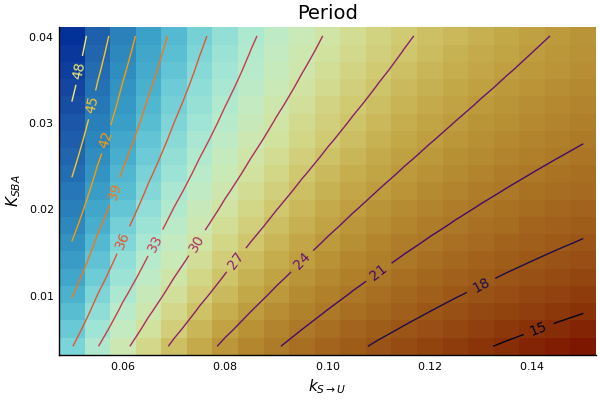

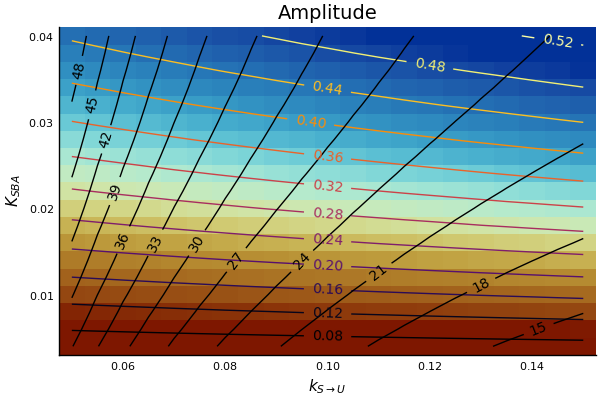

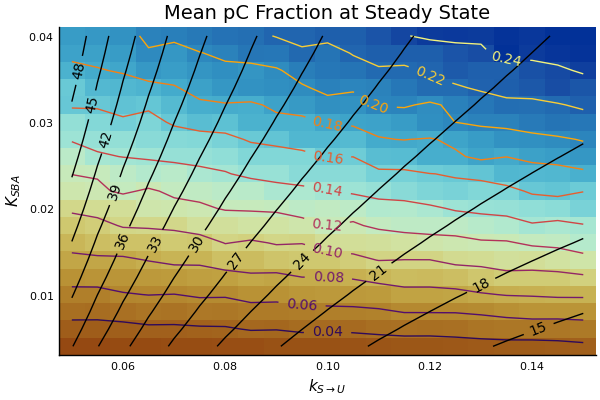

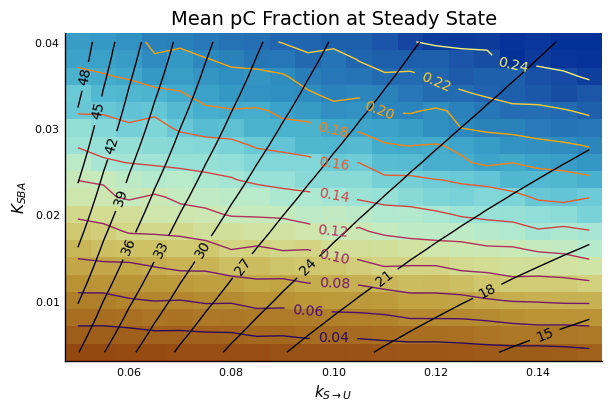

In [62]:
p1 = heatmap(kSU_vec, K_SBA_vec, transpose(per_mat), 
    xlabel="\$k_{S\\rightarrow U}\$", ylabel="\$K_{SBA}\$", title = "Period", color=:roma, fmt=:png)

contour!(p1, ones(length(K_SBA_vec))*kSU_vec',
    K_SBA_vec*ones(length(kSU_vec))', 
    transpose(per_mat), 
    levels=12, clabels=true, cbar=false, lw=1)

display(p1)

p2 = heatmap(kSU_vec, K_SBA_vec, transpose(amp_mat), 
    xlabel="\$k_{S\\rightarrow U}\$", ylabel="\$K_{SBA}\$", title = "Amplitude", color=:roma, fmt=:png)

contour!(ones(length(K_SBA_vec))*kSU_vec',
    K_SBA_vec*ones(length(kSU_vec))', 
    transpose(amp_mat), 
    levels=12, clabels=true, cbar=false,
    lw=1, clims=(0.1, 0.5))

contour!(p2, ones(length(K_SBA_vec))*kSU_vec',
    K_SBA_vec*ones(length(kSU_vec))', 
    transpose(per_mat), 
    levels=12, clabels=true, color=[:black], lw=1)

display(p2)

p3 = heatmap(kSU_vec, K_SBA_vec, transpose(pC_mat), clims=(0, 0.25),
    xlabel="\$k_{S\\rightarrow U}\$", ylabel="\$K_{SBA}\$", title = "Mean pC Fraction at Steady State", color=:roma, fmt=:png)

contour!(ones(length(K_SBA_vec))*kSU_vec',
    K_SBA_vec*ones(length(kSU_vec))', 
    transpose(pC_mat), 
    levels=12, clabels=true, cbar=false, 
    lw=1)

contour!(p3, ones(length(K_SBA_vec))*kSU_vec',
    K_SBA_vec*ones(length(kSU_vec))', 
    transpose(per_mat), 
    levels=12, clabels=true, color=[:black], lw=1)


display(p3)

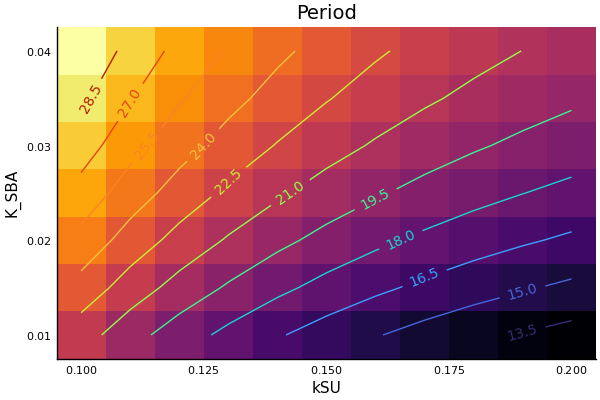

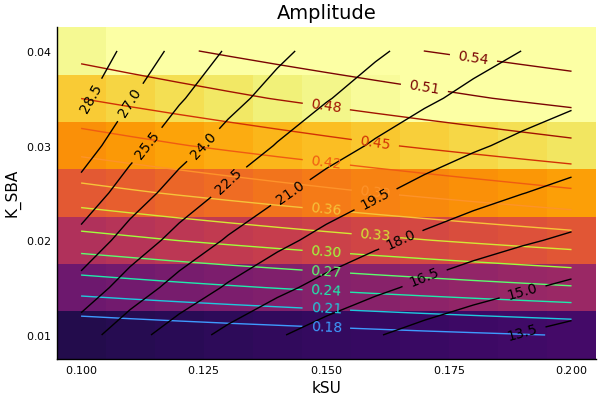

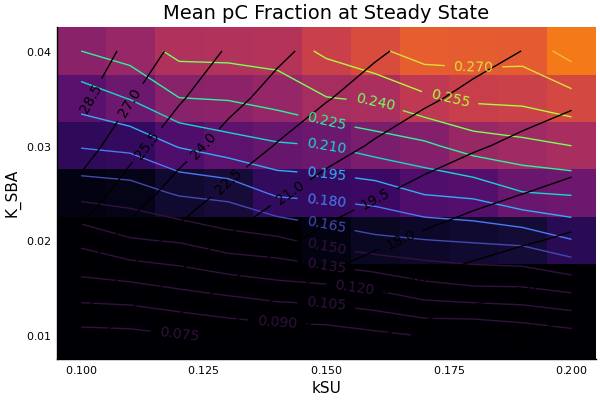

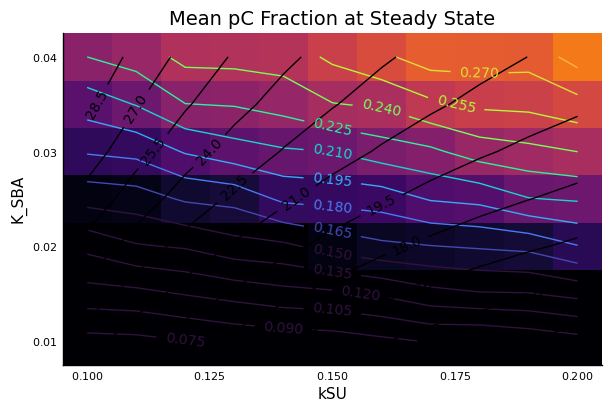

In [35]:
p1 = heatmap(kSU_vec, K_SBA_vec, transpose(per_mat), xlabel="kSU", ylabel="K_SBA", title = "Period")

contour!(p1, ones(length(K_SBA_vec))*kSU_vec',
    K_SBA_vec*ones(length(kSU_vec))', 
    transpose(per_mat), 
    levels=14, color=:turbo, clabels=true, cbar=false, lw=1)

display(p1)

p2 = heatmap(kSU_vec, K_SBA_vec, transpose(amp_mat), xlabel="kSU", ylabel="K_SBA", title = "Amplitude")

contour!(ones(length(K_SBA_vec))*kSU_vec',
    K_SBA_vec*ones(length(kSU_vec))', 
    transpose(amp_mat), 
    levels=14, color=:turbo, clabels=true, cbar=false,
    lw=1, clims=(0.1, 0.5))

contour!(p2, ones(length(K_SBA_vec))*kSU_vec',
    K_SBA_vec*ones(length(kSU_vec))', 
    transpose(per_mat), 
    levels=14, clabels=true, color=[:black], lw=1)

display(p2)

p3 = heatmap(kSU_vec, K_SBA_vec, transpose(pC_mat), xlabel="kSU", ylabel="K_SBA", title = "Mean pC Fraction at Steady State")

contour!(ones(length(K_SBA_vec))*kSU_vec',
    K_SBA_vec*ones(length(kSU_vec))', 
    transpose(pC_mat), 
    levels=14, color=:turbo, clabels=true, cbar=false, 
    lw=1, clims=(0.15, 0.35))

contour!(p3, ones(length(K_SBA_vec))*kSU_vec',
    K_SBA_vec*ones(length(kSU_vec))', 
    transpose(per_mat), 
    levels=14, clabels=true, color=[:black], lw=1)


display(p3)

Extract controur coordinates

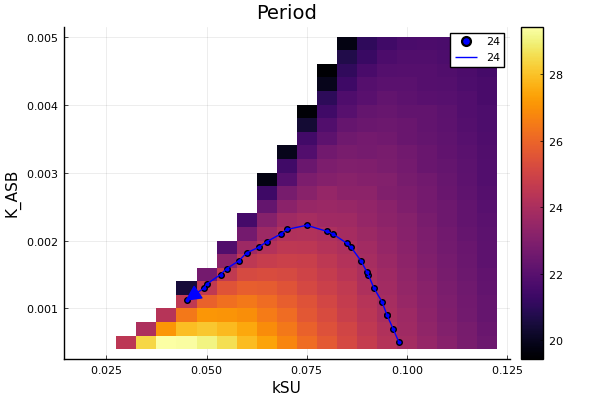

sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


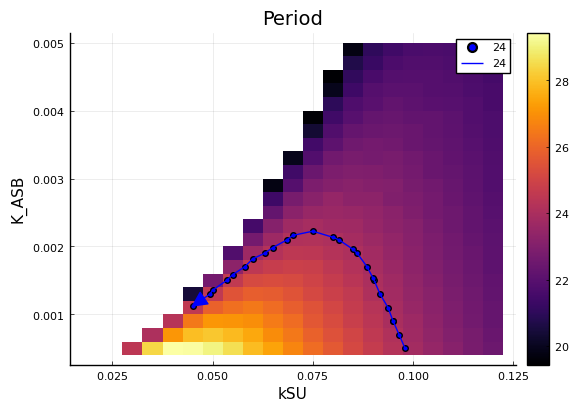

In [55]:
p4 = plot()
heatmap!(p4, kSU_vec, K_ASB_vec, transpose(per_mat), xlabel="kSU", ylabel="K_ASB", title = "Period")

cls = levels(contours(kSU_vec, K_ASB_vec, per_mat, [24]))
isochrone = Dict()
for cl in cls
    lvl = level(cl) # the z-value of this contour level
    isochrone[lvl] = []
    for line in lines(cl)
        xs, ys = coordinates(line) # coordinates of this line segment
        isochrone[lvl] = [isochrone[lvl]..., (xs, ys)]
        scatter!(p4, xs, ys, label="$(lvl)", c=:blue) # pseuod-code; use whatever plotting package you prefer
        plot!(p4, xs, ys, arrow=(:closed, 1.), label="$(lvl)", c=:blue)
    end
end

display(p4)

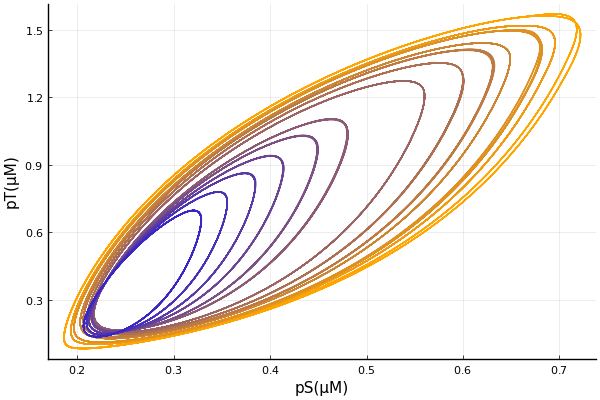

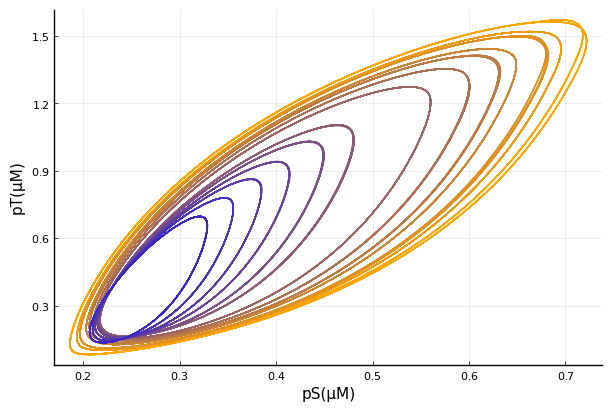

In [72]:
# master parameters
M_new = 6.

# constants
tmax = 480
istart = 3001

p1 = plot(legend=false)
#p2 = plot(legendtitle="M")

kSU_24 = isochrone[24][1][1]
K_SBA_24 = isochrone[24][1][2]

pal = palette(cgrad([:orange, :blue]), length(kSU_24))

for i in 1:2:length(kSU_24)
    
    if isnan(kSU_24[i]) || isnan(K_SBA_24[i])
        continue
    end
    
    P0 = [3.5, 0, 0, 0, 0, 0]
    
    p = (kUTA, kTU, kTUA, kTDA, kDT, kDTA, kDS, kDSA, kSDA, kSU_24[i], kSUA, kUSA, kCIhyd,
        KA, A0, fATP, 0., M_new, K_SBA_24[i])

    prob = ODEProblem(kaiabc_phong_low_temp3!, P0, (0.0, tmax), p)
    sol = solve(prob, Tsit5(), saveat = 0.1)

    pS = sum(hcat(sol.u...)[[3, 4, 5, 6], :], dims=1)
    #pS = sum(hcat(sol.u...)[[6], :], dims=1)
    pT = sum(hcat(sol.u...)[[2, 3, 5], :], dims=1)

    plot!(p1, pS'[istart:end], pT'[istart:end],c=pal[i])
    #plot!(p2, sol.t, hcat(sol.u...)[6, :], label="$(M_new)")
    
end

xlabel!(p1, "pS(μM)")
ylabel!(p1, "pT(μM)")
display(p1)


## Exploring stoichiometry

In [73]:
function solve_SBA(Atot; M = 6., Kd = 1e-3, SB = 3.5)
    Delta = (M*SB + Atot + Kd)^2 - 4M*Atot*SB
    SBA = 1/(2M)*(M*SB + Atot + Kd - sqrt(Delta))
    return SBA
end

solve_SBA (generic function with 1 method)

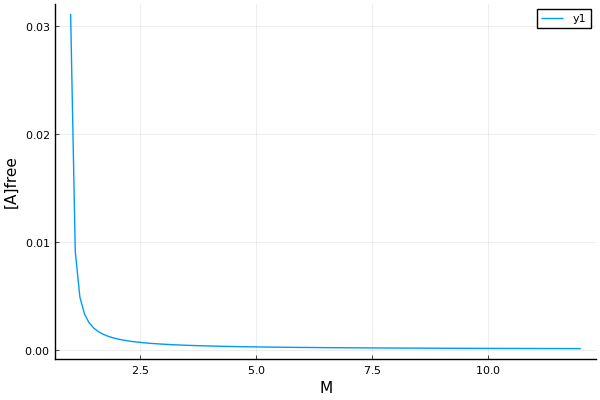

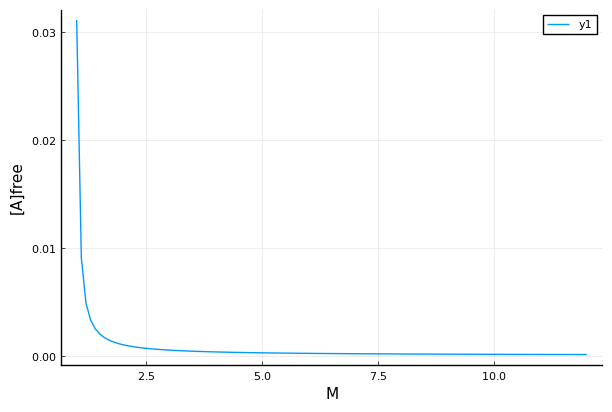

In [80]:
M_vec = 1:0.1:12.
Atot = 1.0

p1 = plot(M_vec, (m -> Atot - m*solve_SBA(Atot; M = m, SB = 1.)).(M_vec))
xlabel!("M")
ylabel!("[A]free")
display(p1)

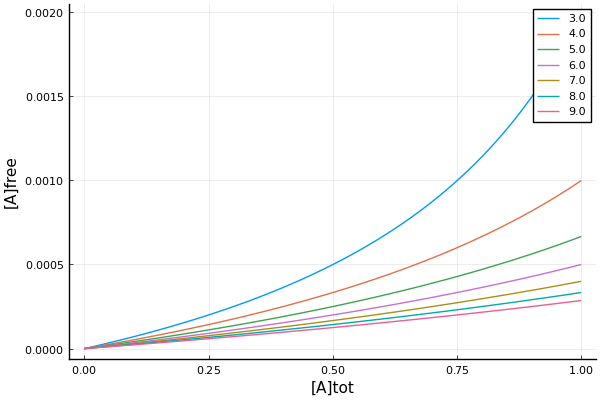

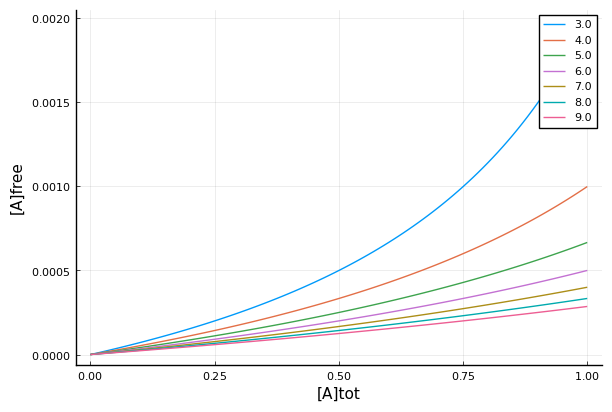

In [77]:
Atot_vec = 0:0.01:1.

M_vec = 3.:1.:9.

p1 = plot()
for M in M_vec
    plot!(Atot_vec, Atot_vec .- M*solve_SBA.(Atot_vec; M = M, SB = 0.5, Kd = 1e-3), label="$(M)")
end
xlabel!("[A]tot")
ylabel!("[A]free")

display(p1)

Experimentally we've shown that the $S \rightarrow U$ reaction is inhibited at low temperatures while $D \rightarrow S$ less so,
which hints accumulation of S species at low temperatures.
Since SB complex sequesters KaiA which is strictly required to phosphorylate KaiC, the accumulation of S is expected to delay KaiC phosphorylation which, overall, lengthens the period.

However, in terms of phenomenology we know that the period is compensated with varying temperatures.
There has to be one or more temperature dependent reactions that balance the period-lengthening effect of the slowed down
$S \rightarrow U$ step.


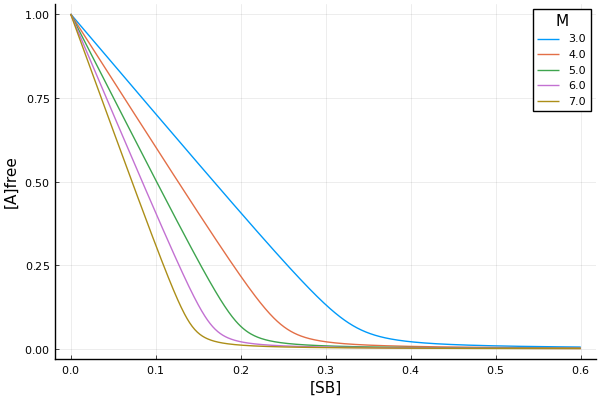

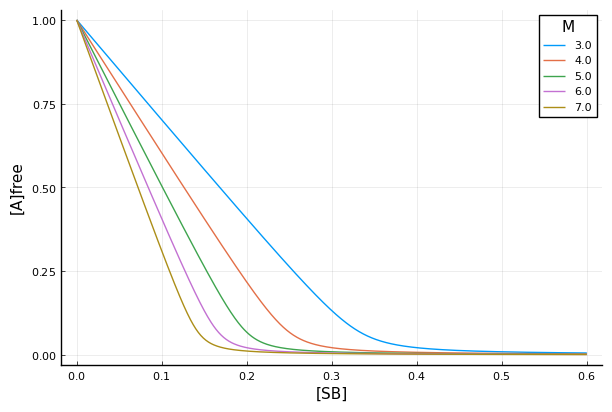

In [225]:
SB_vec = 0:0.001:0.6
Atot = 1.

M_vec = 3.:1.:7.

# p = plot(legendtitle = "M", xlim=(0.1, 0.65))
p = plot(legendtitle = "M")
for M in M_vec
    plot!(SB_vec, Atot .- M*(sb -> solve_SBA(Atot; M = M, SB = sb, Kd = 0.005)).(SB_vec), label="$(M)")
end
xlabel!("[SB]")
ylabel!("[A]free")

display(p)

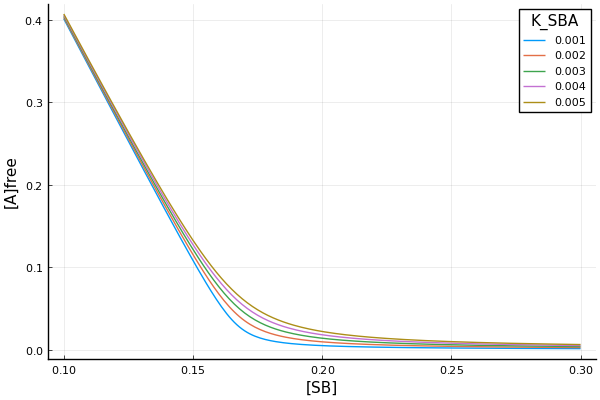

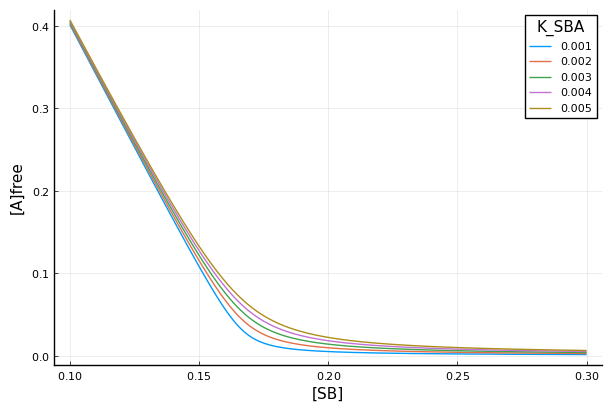

In [227]:
SB_vec = 0.1:0.001:0.3
Atot = 1.

K_SBA_vec = 1e-3:1e-3:5e-3
# K_SBA_vec = 4e-4:2e-4:1.2e-3

p = plot(legendtitle = "K_SBA")
# p = plot(legendtitle = "K_SBA", xlim=(0.12, 0.3))
for K_SBA in K_SBA_vec
    plot!(SB_vec, Atot .- M*(sb -> solve_SBA(Atot; M = 6., SB = sb, Kd = K_SBA)).(SB_vec), label="$(K_SBA)")
end
xlabel!("[SB]")
ylabel!("[A]free")

display(p)

The Murayama 2017 paper shows that as temperature decreases, though the amplitude also decreases, the mean phosphorylation level is largely unaffected (from $30^\circ C$ all the way to 16. Phosphorylation level goes up at 10).

Is it true in the model either with varying $M$ or varying $K_{SBA}$?

In [81]:
kSU_vec = 0.02:0.004:0.12
M_vec = 2.:0.3:8.

# additional params
A0 = 1.0
fATP = 1.0

# KaiBC-KaiA binding stoichiometry
K_SBA = 0.002

# find period numerically
per_mat = zeros(length(kSU_vec), length(M_vec))
amp_mat = zeros(length(kSU_vec), length(M_vec))
pC_mat = zeros(length(kSU_vec), length(M_vec))

for (i, kSU_cold) in enumerate(kSU_vec)
    for (j, M_new) in enumerate(M_vec)
        # initial conditions
        u0 = [3.5, 0, 0, 0, 0, 0]
        
        p = (kUTA, kTU, kTUA, kTDA, kDT, kDTA, kDS, kDSA, kSDA, kSU_cold, kSUA, kUSA, kCIhyd,
        KA, A0, fATP, 0., M_new, K_SBA)
        
        conv_t, amplitude, per, phase = 
        attracted_to(kaiabc_phong_low_temp3!, u0, 168, p; 
        burnin=96, conv_tol=5e-2, amp_cutoff=5e-2, tmax_stop=1e3)

        per_mat[i, j] = per == -1 ? NaN : per
        amp_mat[i, j] = amplitude == -1 ? NaN : amplitude
        
        # solve it one more time to get mean fraction of pC
        prob = ODEProblem(kaiabc_phong_low_temp3!, u0, (0.0, conv_t + 1000.), p)
        sol = solve(prob, reltol=1e-8, abstol=1e-8)
        mean_pC = conv_t < 0 ? NaN : mean(phospho_C(sol.u[sol.t .> conv_t]))
        
        pC_mat[i, j] = mean_pC
        
        print("kSU=$(kSU_cold); M=$(M_new); amp=$(amplitude); per=$(per); pC=$(mean_pC)\n")
    end
end

kSU=0.02; M=2.0; amp=-1; per=-1; pC=NaN
kSU=0.02; M=2.3; amp=-1; per=-1; pC=0.3263812047288559
kSU=0.02; M=2.6; amp=-1; per=-1; pC=0.3168841724331472
kSU=0.02; M=2.9; amp=-1; per=-1; pC=0.3080035223606055
kSU=0.02; M=3.2; amp=-1; per=-1; pC=0.2998405669748937
kSU=0.02; M=3.5; amp=-1; per=-1; pC=0.29121670172891817
kSU=0.02; M=3.8; amp=-1; per=-1; pC=0.2810533261141835
kSU=0.02; M=4.1; amp=-1; per=-1; pC=0.278270082916181
kSU=0.02; M=4.4; amp=-1; per=-1; pC=0.27077070846834084
kSU=0.02; M=4.7; amp=-1; per=-1; pC=0.26052882018501067
kSU=0.02; M=5.0; amp=-1; per=-1; pC=0.25929828543726174
kSU=0.02; M=5.3; amp=-1; per=-1; pC=NaN
kSU=0.02; M=5.6; amp=-1; per=-1; pC=NaN
kSU=0.02; M=5.9; amp=-1; per=-1; pC=NaN
kSU=0.02; M=6.2; amp=-1; per=-1; pC=NaN
kSU=0.02; M=6.5; amp=-1; per=-1; pC=NaN
kSU=0.02; M=6.8; amp=-1; per=-1; pC=NaN
kSU=0.02; M=7.1; amp=-1; per=-1; pC=NaN
kSU=0.02; M=7.4; amp=-1; per=-1; pC=NaN
kSU=0.02; M=7.7; amp=-1; per=-1; pC=NaN
kSU=0.02; M=8.0; amp=-1; per=-1; pC=NaN
kSU=0.0

kSU=0.044; M=5.0; amp=-1; per=-1; pC=0.20530175937148207
kSU=0.044; M=5.3; amp=-1; per=-1; pC=0.20211505183667355
kSU=0.044; M=5.6; amp=-1; per=-1; pC=0.20046842160328476
kSU=0.044; M=5.9; amp=-1; per=-1; pC=0.19642629820485566
kSU=0.044; M=6.2; amp=-1; per=-1; pC=0.20462872580442218
kSU=0.044; M=6.5; amp=-1; per=-1; pC=0.19944470478992773
kSU=0.044; M=6.8; amp=-1; per=-1; pC=0.20051437900816568
kSU=0.044; M=7.1; amp=-1; per=-1; pC=0.19981721467877536
kSU=0.044; M=7.4; amp=-1; per=-1; pC=0.19865535944814935
kSU=0.044; M=7.7; amp=-1; per=-1; pC=0.19660483327465253
kSU=0.044; M=8.0; amp=-1; per=-1; pC=0.19548190344088018
kSU=0.048; M=2.0; amp=0.4787498506870924; per=37.0890913866873; pC=0.4578142861495946
kSU=0.048; M=2.3; amp=0.46088561105049186; per=36.0568028444076; pC=0.42131790032687183
kSU=0.048; M=2.6; amp=0.4378516161679519; per=34.973540997023925; pC=0.38766510148437183
kSU=0.048; M=2.9; amp=0.4116255668256489; per=33.91125099004757; pC=0.3569644046340581
kSU=0.048; M=3.2; amp=0

kSU=0.064; M=5.9; amp=0.2604699590223187; per=24.210345947137373; pC=0.234641722522442
kSU=0.064; M=6.2; amp=0.23328782206052162; per=23.24635819043415; pC=0.22301126090676338
kSU=0.064; M=6.5; amp=0.20541722643628452; per=22.418449222366792; pC=0.21265540601171448
kSU=0.064; M=6.8; amp=0.17303091304249932; per=21.368238161664767; pC=0.20144643017863034
kSU=0.064; M=7.1; amp=0.13625615405373961; per=20.20093293753325; pC=0.18918416293331083
kSU=0.064; M=7.4; amp=-1; per=-1; pC=0.178190459269116
kSU=0.064; M=7.7; amp=-1; per=-1; pC=0.17537469782154155
kSU=0.064; M=8.0; amp=-1; per=-1; pC=0.1727145088874787
kSU=0.068; M=2.0; amp=0.5038962379811811; per=33.13867012521316; pC=0.48946116053600247
kSU=0.068; M=2.3; amp=0.4987761042119995; per=32.095967729473976; pC=0.4551277276367496
kSU=0.068; M=2.6; amp=0.48939547359791485; per=31.362531971715562; pC=0.4295093441432441
kSU=0.068; M=2.9; amp=0.4766019730586878; per=30.667112944504805; pC=0.4050053507495684
kSU=0.068; M=3.2; amp=0.4620170698

kSU=0.084; M=3.2; amp=0.4867861807775141; per=28.08411719484357; pC=0.40763018033826304
kSU=0.084; M=3.5; amp=0.4759158570484693; per=27.57229236724058; pC=0.38712178635829014
kSU=0.084; M=3.8; amp=0.4633600734183642; per=27.061089446004882; pC=0.3713019927812046
kSU=0.084; M=4.1; amp=0.4500871742234399; per=26.742951896509194; pC=0.355429587732372
kSU=0.084; M=4.4; amp=0.4367464161277194; per=26.304020365016576; pC=0.34046204665319624
kSU=0.084; M=4.7; amp=0.42290097195782667; per=25.82451349926346; pC=0.32773267432799474
kSU=0.084; M=5.0; amp=0.4079253480452465; per=25.403911579154354; pC=0.3127369016698009
kSU=0.084; M=5.3; amp=0.39364757265608186; per=25.058508611207913; pC=0.3029878971807991
kSU=0.084; M=5.6; amp=0.37875778446341357; per=24.565008811513618; pC=0.29029580349072315
kSU=0.084; M=5.9; amp=0.36374771917908794; per=24.14773958626996; pC=0.2800379990242829
kSU=0.084; M=6.2; amp=0.3485434047393617; per=23.729320189195985; pC=0.2707634664826499
kSU=0.084; M=6.5; amp=0.3325

kSU=0.1; M=6.2; amp=0.3910393748950343; per=22.952654809463592; pC=0.2980191231389299
kSU=0.1; M=6.5; amp=0.37952206331785476; per=22.61319668497505; pC=0.28706330791403156
kSU=0.1; M=6.8; amp=0.3662008364930459; per=22.283835531547982; pC=0.27985317562281203
kSU=0.1; M=7.1; amp=0.35458595071437427; per=21.954787749254297; pC=0.2696861990013649
kSU=0.1; M=7.4; amp=0.3420619155294423; per=21.666683207915774; pC=0.2634491728587118
kSU=0.1; M=7.7; amp=0.3288656375076016; per=21.343271591161823; pC=0.2562395459495267
kSU=0.1; M=8.0; amp=0.3166180978907933; per=21.003485426319727; pC=0.2483340350269937
kSU=0.104; M=2.0; amp=0.49477692819860974; per=30.659267582937403; pC=0.5316719190148568
kSU=0.104; M=2.3; amp=0.5044486899306369; per=28.815716865863628; pC=0.49796082041297834
kSU=0.104; M=2.6; amp=0.5070253359872349; per=27.72560616955302; pC=0.46999412571460714
kSU=0.104; M=2.9; amp=0.504625778187502; per=26.94460031133285; pC=0.44918939729186264
kSU=0.104; M=3.2; amp=0.49976112201821243;

kSU=0.12; M=2.9; amp=0.5042844766144624; per=26.034466771249082; pC=0.46327990465698604
kSU=0.12; M=3.2; amp=0.5026565393401157; per=25.37291813312157; pC=0.4443242423202828
kSU=0.12; M=3.5; amp=0.49826477606839437; per=24.854762073748972; pC=0.4277039438380572
kSU=0.12; M=3.8; amp=0.4929056334283767; per=24.354905136736722; pC=0.4112534047568521
kSU=0.12; M=4.1; amp=0.4860566392009811; per=24.036934973977527; pC=0.39880865297388246
kSU=0.12; M=4.4; amp=0.4788625540564544; per=23.657788195717387; pC=0.38594810246299766
kSU=0.12; M=4.7; amp=0.4702427592449041; per=23.284483682880566; pC=0.374169855609838
kSU=0.12; M=5.0; amp=0.4615024548305374; per=23.03333358046592; pC=0.36174824268968514
kSU=0.12; M=5.3; amp=0.45259775201523944; per=22.780781887461522; pC=0.3506800068271925
kSU=0.12; M=5.6; amp=0.4433001184129382; per=22.45776621368087; pC=0.3414598192181658
kSU=0.12; M=5.9; amp=0.43352190950407465; per=22.162130082656315; pC=0.3312251045590673
kSU=0.12; M=6.2; amp=0.42294187779099646

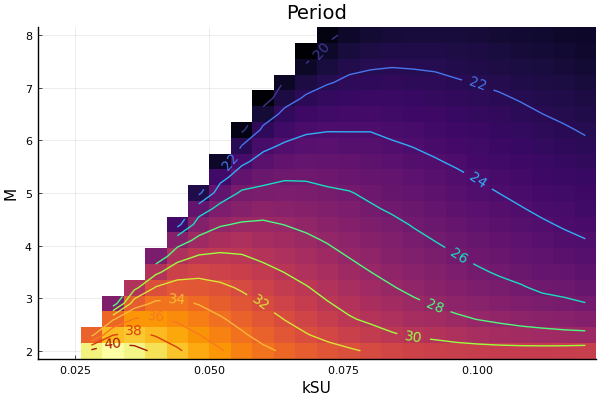

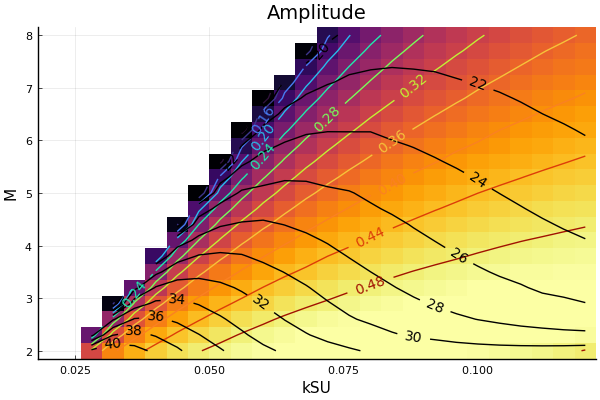

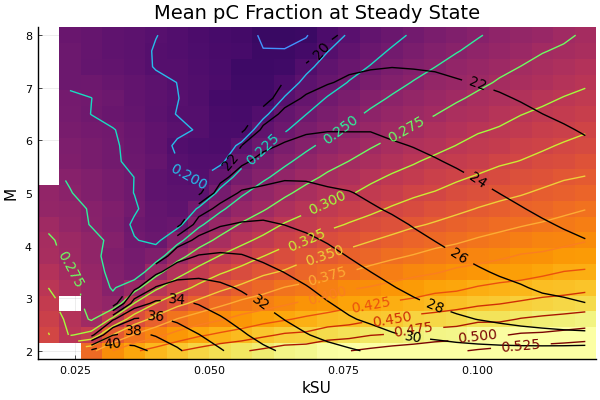

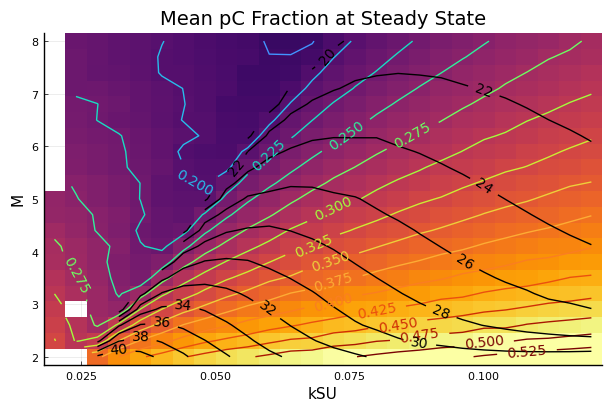

In [82]:
p1 = heatmap(kSU_vec, M_vec, transpose(per_mat), xlabel="kSU", ylabel="M", title = "Period")

contour!(p1, ones(length(M_vec))*kSU_vec',
    M_vec*ones(length(kSU_vec))', 
    transpose(per_mat), 
    levels=14, color=:turbo, clabels=true, cbar=false, lw=1)

display(p1)

p2 = heatmap(kSU_vec, M_vec, transpose(amp_mat), xlabel="kSU", ylabel="M", title = "Amplitude")

contour!(ones(length(M_vec))*kSU_vec',
    M_vec*ones(length(kSU_vec))', 
    transpose(amp_mat), 
    levels=14, color=:turbo, clabels=true, cbar=false,
    lw=1, clims=(0.1, 0.5))

contour!(p2, ones(length(M_vec))*kSU_vec',
    M_vec*ones(length(kSU_vec))', 
    transpose(per_mat), 
    levels=14, clabels=true, color=[:black], lw=1)

display(p2)

p3 = heatmap(kSU_vec, M_vec, transpose(pC_mat), xlabel="kSU", ylabel="M", title = "Mean pC Fraction at Steady State")

contour!(ones(length(M_vec))*kSU_vec',
    M_vec*ones(length(kSU_vec))', 
    transpose(pC_mat), 
    levels=14, color=:turbo, clabels=true, cbar=false, 
    lw=1, clims=(0.1, 0.5))

contour!(p3, ones(length(M_vec))*kSU_vec',
    M_vec*ones(length(kSU_vec))', 
    transpose(per_mat), 
    levels=14, clabels=true, color=[:black], lw=1)


display(p3)

Extract contour coordinates

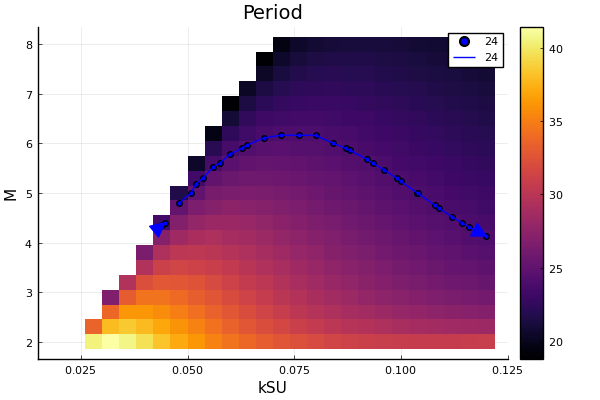

sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


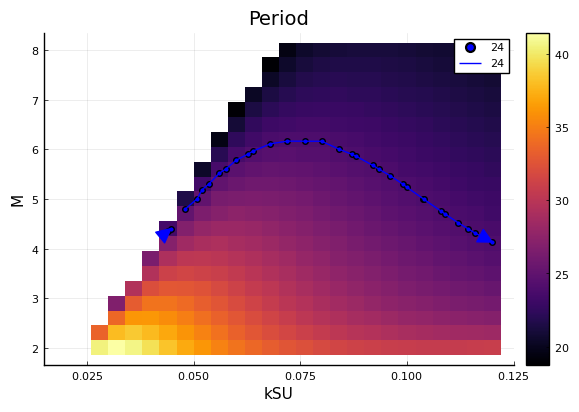

In [83]:
p4 = plot()
heatmap!(p4, kSU_vec, M_vec, transpose(per_mat), xlabel="kSU", ylabel="M", title = "Period")

cls = levels(contours(kSU_vec, M_vec, per_mat, [24]))
isochrone = Dict()
for cl in cls
    lvl = level(cl) # the z-value of this contour level
    isochrone[lvl] = []
    for line in lines(cl)
        xs, ys = coordinates(line) # coordinates of this line segment
        isochrone[lvl] = [isochrone[lvl]..., (xs, ys)]
        scatter!(p4, xs, ys, label="$(lvl)", c=:blue) # pseuod-code; use whatever plotting package you prefer
        plot!(p4, xs, ys, arrow=(:closed, 1.), label="$(lvl)", c=:blue)
    end
end

display(p4)

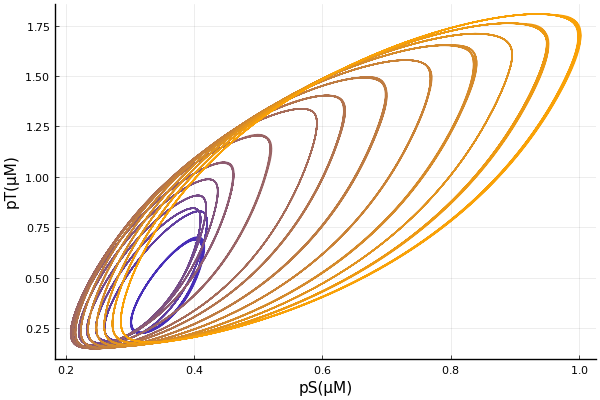

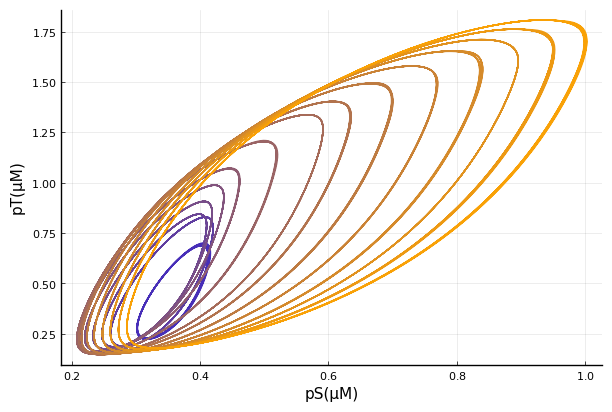

In [86]:
# master parameters
K_SBA = 0.002

# constants
tmax = 480
istart = 3001

p1 = plot(legend=false)

kSU_24 = isochrone[24][1][1]
M_24 = isochrone[24][1][2]

pal = palette(cgrad([:blue, :orange]), length(kSU_24))

for i in 1:2:length(kSU_24)
    
    if isnan(kSU_24[i]) || isnan(M_24[i])
        continue
    end
    
    P0 = [3.5, 0, 0, 0, 0, 0]
    
    p = (kUTA, kTU, kTUA, kTDA, kDT, kDTA, kDS, kDSA, kSDA, kSU_24[i], kSUA, kUSA, kCIhyd,
        KA, A0, fATP, 0., M_24[i], K_SBA)

    prob = ODEProblem(kaiabc_phong_low_temp3!, P0, (0.0, tmax), p)
    sol = solve(prob, Tsit5(), saveat = 0.1)

    pS = sum(hcat(sol.u...)[[3, 4, 5, 6], :], dims=1)
    #pS = sum(hcat(sol.u...)[[6], :], dims=1)
    pT = sum(hcat(sol.u...)[[2, 3, 5], :], dims=1)

    plot!(p1, pS'[istart:end], pT'[istart:end],c=pal[i])
    
end

xlabel!(p1, "pS(μM)")
ylabel!(p1, "pT(μM)")
display(p1)


Limit cycle in the pS-pT space as M or Kd changes

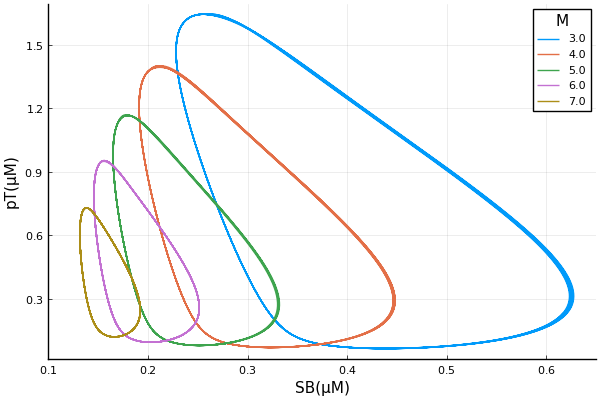

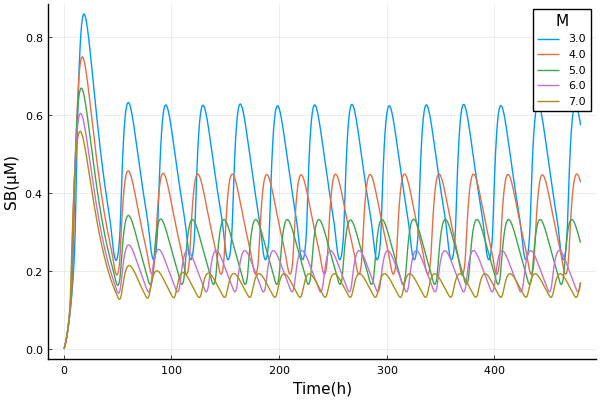

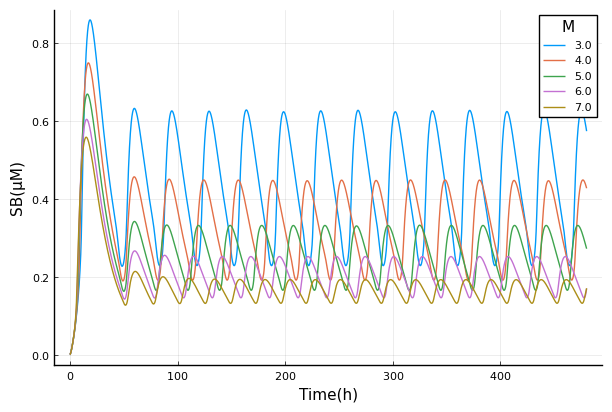

In [39]:
# master parameters
K_SBA = 0.001
M_new = 6.
kSU_new = 0.05

# Vary M
M_vec = 3.:1.:7.

# constants
tmax = 480
istart = 2001

p1 = plot(legendtitle="M", xlim=(0.1, 0.65))
p2 = plot(legendtitle="M")
for M_new in M_vec
    
    P0 = [3.5, 0, 0, 0, 0, 0]
    
    p = (kUTA, kTU, kTUA, kTDA, kDT, kDTA, kDS, kDSA, kSDA, kSU_new, kSUA, kUSA, kCIhyd,
        KA, A0, fATP, 0., M_new, K_SBA)

    prob = ODEProblem(kaiabc_phong_low_temp3!, P0, (0.0, tmax), p)
    sol = solve(prob, Tsit5(), saveat = 0.1)

    #pS = sum(hcat(sol.u...)[[3, 4, 5, 6], :], dims=1)
    pS = sum(hcat(sol.u...)[[6], :], dims=1)
    pT = sum(hcat(sol.u...)[[2, 3, 5], :], dims=1)

    plot!(p1, pS'[istart:end], pT'[istart:end], label="$(M_new)")
    plot!(p2, sol.t, hcat(sol.u...)[6, :], label="$(M_new)")
    
end

xlabel!(p1, "SB(μM)")
ylabel!(p1, "pT(μM)")
display(p1)

xlabel!(p2, "Time(h)")
ylabel!(p2, "SB(μM)")
display(p2)

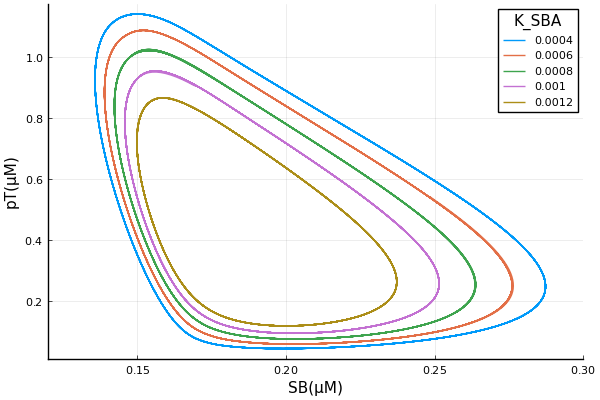

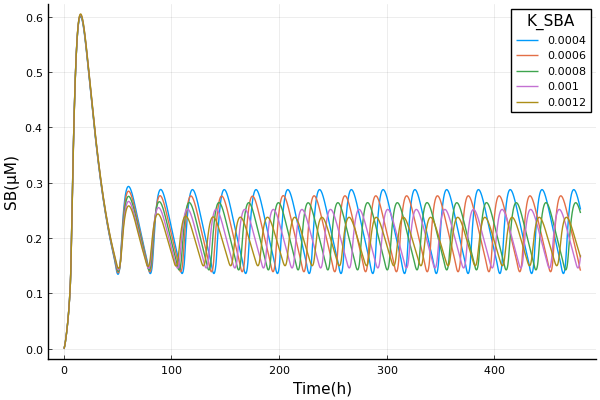

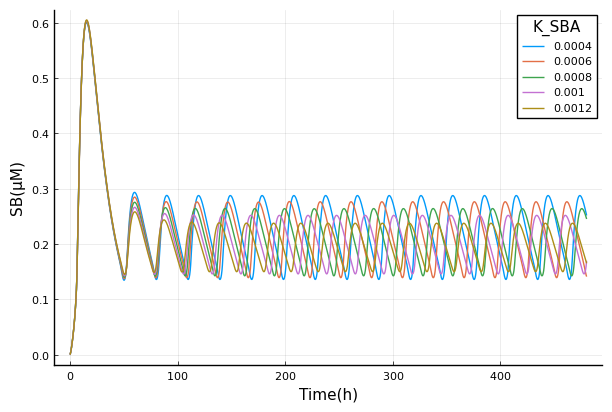

In [40]:
# master parameters
K_SBA = 0.001
M_new = 6.
kSU_new = 0.05

# Vary Kd
K_SBA_vec = 4e-4:2e-4:1.2e-3

# constants
tmax = 480
istart = 2001

p1 = plot(legendtitle="K_SBA", xlim=(0.12, 0.3))
p2 = plot(legendtitle="K_SBA")
for K_SBA in K_SBA_vec
    
    P0 = [3.5, 0, 0, 0, 0, 0]
    
    p = (kUTA, kTU, kTUA, kTDA, kDT, kDTA, kDS, kDSA, kSDA, kSU_new, kSUA, kUSA, kCIhyd,
        KA, A0, fATP, 0., M_new, K_SBA)

    prob = ODEProblem(kaiabc_phong_low_temp3!, P0, (0.0, tmax), p)
    sol = solve(prob, Tsit5(), saveat = 0.1)

    #pS = sum(hcat(sol.u...)[[3, 4, 5, 6], :], dims=1)
    pS = sum(hcat(sol.u...)[[6], :], dims=1)
    pT = sum(hcat(sol.u...)[[2, 3, 5], :], dims=1)

    plot!(p1, pS'[istart:end], pT'[istart:end], label="$(K_SBA)")
    plot!(p2, sol.t, hcat(sol.u...)[6, :], label="$(K_SBA)")
    
end

xlabel!(p1, "SB(μM)")
ylabel!(p1, "pT(μM)")
display(p1)

xlabel!(p2, "Time(h)")
ylabel!(p2, "SB(μM)")
display(p2)